In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [ ]:
df = pd.read_csv('/Users/ignat/Desktop/Demand/demand_forecasting/data/ML.csv', parse_dates=['Date'])
#df = pd.read_csv('/Users/ignat/Desktop/Demand/demand_forecasting/data/ML_69.csv', parse_dates=['Date'])
# === Преобразование даты ===
df['Date'] = pd.to_datetime(df['Date'])
df['Freight_Lag24'] = df['Freight_Price'].shift(24)
df['Oil_Lag1'] = df['Oil_Price'].shift(1)
df['Oil_Lag2'] = df['Oil_Price'].shift(2)
df['Oil_SMA_3'] = df['Oil_Price'].rolling(3).mean()
df['Oil_Lag6'] = df['Oil_Price'].shift(6)
df['Oil_Lag12'] = df['Oil_Price'].shift(12)
df['Oil_Change_1m'] = df['Oil_Price'].pct_change(periods=1)
# === Логарифм целевой переменной ===
df['Log_Freight'] = np.log1p(df['Freight_Price'])

# === Удаляем строки с пропущенными значениями
df = df.dropna().reset_index(drop=True)

# === Разделение на train/test ===
train = df[df['Date'] < '2023-01-03'].copy()
test = df[(df['Date'] >= '2023-01-03') & (df['Date'] <= '2025-01-03')].copy()

# print(f"Train: {train['Date'].min().date()} → {train['Date'].max().date()}")
# print(f"Test:  {test['Date'].min().date()} → {test['Date'].max().date()}")
#df.head(20)


In [3]:
train = df[(df['Date'] >= '2011-01-03') & (df['Date'] < '2017-01-03')].copy()
test = df[(df['Date'] >= '2017-01-03') & (df['Date'] < '2019-01-03')].copy()

In [19]:
used_features = [
    # макро- и внешние признаки
    #'Oil_Price',
    'Oil_Lag1', 
    'Oil_SMA_3',
    'Oil_Lag6',
    'Oil_Lag12',
    'Freight_Lag24'
]


# === Подготовка датафрейма для Prophet ===
def prepare_df(df_part):
    df_model = df_part[['Date', 'Log_Freight'] + used_features].copy()
    df_model = df_model.rename(columns={'Date': 'ds', 'Log_Freight': 'y'})
    return df_model

freight_train = prepare_df(train)
future = prepare_df(test)
# === Добавим пользовательские события ===
crisis_events = pd.DataFrame({
    'holiday': [
        'covid_lockdown', 
        'suez_blockage', 
        'ukraine_conflict', 
        'china_port_closure',
        'inflation_peak'
    ],
    'ds': pd.to_datetime([
        '2020-03-15', 
        '2021-03-23', 
        '2022-02-24', 
        '2021-08-01', 
        '2022-06-01'
    ]),
    'lower_window': 0,  # день события
    'upper_window': 165 # и 2 дня после
})

# === Обучение модели ===
model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=2,
    holidays=crisis_events
)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)



for feature in used_features:
    model.add_regressor(feature)

model.fit(freight_train)

# === Прогноз ===
forecast = model.predict(future)
test = test.merge(forecast[['ds', 'yhat']], left_on='Date', right_on='ds', how='left')
test['yhat_exp'] = np.expm1(test['yhat'])

12:35:21 - cmdstanpy - INFO - Chain [1] start processing
12:35:26 - cmdstanpy - INFO - Chain [1] done processing


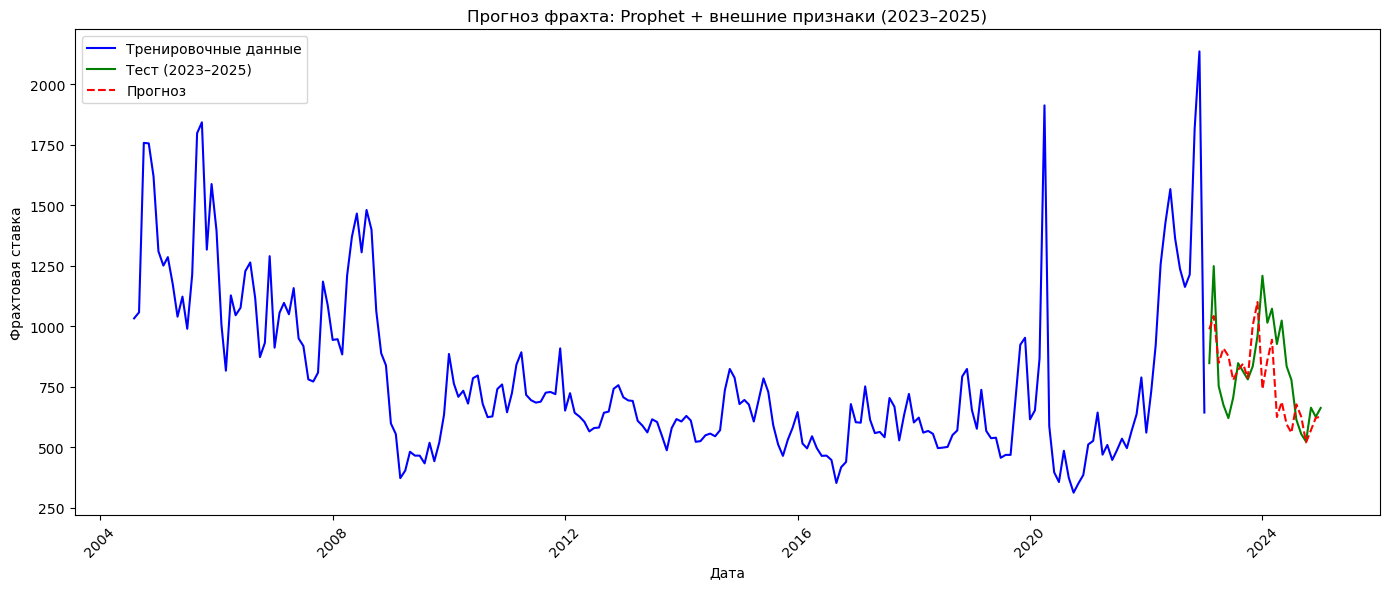

----- Test (2023-2025) -----
MAE : 145.69
RMSE : 186.43


In [20]:
# === Визуализация ===
plt.figure(figsize=(14, 6))
plt.plot(train['Date'], train['Freight_Price'], label='Тренировочные данные', color='blue')
plt.plot(test['Date'], test['Freight_Price'], label='Тест (2023–2025)', color='green')
plt.plot(test['Date'], test['yhat_exp'], '--', label='Прогноз', color='red')

plt.title("Прогноз фрахта: Prophet + внешние признаки (2023–2025)")
plt.xlabel("Дата")
plt.ylabel("Фрахтовая ставка")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Метрики ===
mae = mean_absolute_error(test['Freight_Price'], test['yhat_exp'])
rmse = root_mean_squared_error(test['Freight_Price'], test['yhat_exp'])

print("----- Test (2023-2025) -----")
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
